# Problems 12 - Neural Networks

In this notebook we will be using <a href="https://pytorch.org/">PyTorch</a>, an open source machine learning framework, that allows us to easily define and train neural network models. <a href="https://pytorch.org/">PyTorch</a> is a Python based scientific computing package targeted at two types of audience:

-  At the low level, it is a tensor library capable to exploit the computational power of GPUs
-  At the high level, it is a deep learning research platform that provides maximum flexibility and speed

In [1]:
import torch

At the core of PyTorch there is the `Tensor` class. It is very much like numpy's arrays, but supports autograd.

In [2]:
# Generate a tensor of size 2x3
t = torch.Tensor(2, 3)
type(t)

torch.Tensor

In [3]:
t.shape

torch.Size([2, 3])

In [4]:
t.dim()

2

In [5]:
t

tensor([[6.7262e-44, 8.1275e-44, 6.8664e-44],
        [7.7071e-44, 8.1275e-44, 7.0065e-44]])

Next we will play with vectors

In [6]:
# Creates a 1D tensor of integers 1 to 4
v = torch.Tensor([1, 2, 3, 4])
v

tensor([1., 2., 3., 4.])

In [7]:
w = torch.Tensor([1, 0, 2, 0])
w

tensor([1., 0., 2., 0.])

In [8]:
# Element-wise multiplication
v * w

tensor([1., 0., 6., 0.])

In [9]:
# Scalar product: 1*1 + 2*0 + 3*2 + 4*0
v @ w

tensor(7.)

Now let's create a matrix

In [10]:
# Create a 2x4 tensor
m = torch.Tensor([[2, 5, 3, 7],
                  [4, 2, 1, 9]])
m

tensor([[2., 5., 3., 7.],
        [4., 2., 1., 9.]])

Indexing works exactly the same as numpy

In [11]:
# Indexing row 0, column 2 (0-indexed)
m[0][2]

tensor(3.)

In [12]:
# Indexing row 0, column 2 (0-indexed)
m[0, 2]

tensor(3.)

In [13]:
# Indexing column 1, all rows (returns size 2)
m[:, 1]

tensor([5., 2.])

In [14]:
# Scalar product
m @ v

tensor([49., 47.])

In [15]:
# Transpose tensor m, which is essentially 2x4 to 4x2
m.t()

tensor([[2., 4.],
        [5., 2.],
        [3., 1.],
        [7., 9.]])

# Gradient Computation



Apart from using Tensors to calculate stuff, Tensors also track the operations applied on them in order to differentiate them

In [16]:
a = torch.tensor(2.0, requires_grad=True)

b = 5 * a

b.backward()

print(f"Gradient of b with respecto to a: {a.grad}")

Gradient of b with respecto to a: 5.0


Setting `requires_grad` to true tells the autograd engine that we want to compute gradients for this tensor

In [17]:
a = torch.tensor(2.0, requires_grad=True)

b = a ** 2

b.backward()

print(f"Gradient of b with respecto to a: {a.grad}")

Gradient of b with respecto to a: 4.0


In [18]:
a = torch.tensor(2.0, requires_grad=True)

b = 5 * a
c = b**2

c.backward()

print(f"Gradient of c with respecto to a: {a.grad}")

Gradient of c with respecto to a: 100.0


# A Classification Problem

We will now create some random classification data to work on. We will start with an easy example, where the classes are easily separable with a linear surface.

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

We will be creating two sets of points, sampled from two different Gaussians

In [20]:
from sklearn.datasets import make_blobs

N = 300 # number of sample

x_train, y_train = make_blobs(n_samples = N, n_features = 2, centers=[[0, 0.5], [0, -0.5]], cluster_std=0.2) # training data
x_val, y_val = make_blobs(n_samples = N, n_features = 2, centers=[[0, 0.5], [0, -0.5]], cluster_std=0.2) # training data

We will be using PyTorch, therefore we will convert all our data into Tensors

In [21]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

Let's confirm that we have got some reasonable data.

(-2.0, 2.0)

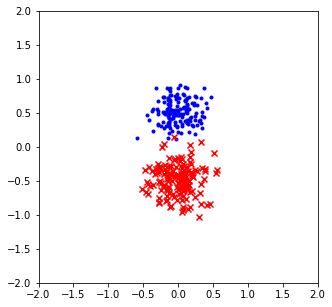

In [22]:
plt.figure(figsize = (5,5))
plt.scatter(x_train[y_train == 0,0], x_train[y_train == 0,1], marker = ".", c = "blue")
plt.scatter(x_train[y_train == 1,0], x_train[y_train == 1,1], marker = "x", c = "red")
plt.ylim(-2, 2)
plt.xlim(-2, 2)

We will also define a function to plot the decision surface of any given model. Do not worry about the following function, just treat it as a black box for the time being.

In [23]:
def plot_model(x, y, model, axis):
    mesh = torch.arange(-2, 2, 0.01)

    xx, yy = torch.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data.detach())
    Z = Z.reshape(xx.shape)
    axis.contourf(xx, yy, Z, levels = [0, 0.5, 1], cmap=plt.cm.coolwarm, alpha=0.3)
    axis.scatter(x[:, 0], x[:, 1], c=y, s=20, cmap=plt.cm.coolwarm)
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])

## 12.1 Recovering Logistic Regression, with Neural Networks

The input data we have is 2-dimensional, hence we define the dimensionality of our input to be equal to 2

In [24]:
dIn = 2

One way to define a neural network using PyTorch, is as a sequence of layers and operations that are applied in order to every input. Look at the manual for more information: https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

To define a simple logistic regression model, we want just one linear layer, that goes from `dIn` dimensions to just 1, this would correspond to a layer with a single neuron. Then we would pass the result of the weighted sum through a Sigmoid function. We defined below the sequence of operations

In [25]:
import torch.nn as nn

modelLogistic = nn.Sequential(
    nn.Linear(dIn, 1), #A linear layer that goes from dIn to 1 dimension
    nn.Sigmoid() # A Sigmoid non-linearity that will be applied to the results of the previous operation
)

The second thing we need to define, is the loss function that we want to use. There are a number of loss functions already defined for us. The "Binary Cross-Entropy" function is the one we used for logistic regression, and it is implemented as `BCELoss()` in PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html

In [26]:
criterion = torch.nn.BCELoss()

The next thing in line is to define what is the optimisation procedure we want to use. The only one we know up to now is simple full-batch gradient descent. This is implemented by the function `SGD()` in PyTorch: https://pytorch.org/docs/stable/generated/torch.optim.SGD.html

Actually, SGD stands for "Stochastic Gradient Descent", but if we pass it the whole batch (all the data) all the time, we will be effectively doing full-batch gradient descent.

When we define an optimiser, we need to tell it which parameters it is supposed to updated every time. In our case, we want it to update all the parameters of our model.

In [27]:
learning_rate = 0.3

# we use the optim package to apply gradient descent for our parameter updates
optimizer = torch.optim.SGD(modelLogistic.parameters(), lr=learning_rate)

The core of our learning, is the training loop, which brings all the above elements together. The idea is that we will do many iterations (epochs) over the whole batch of data, in every time we will:

- pass all our input values through the model and calculate a result (our prediction)
- compare our prediction to the ground truth ("correct") values and calculate the loss, using the criterion function we defined
- zero the gradients of all parameters of our model, and backpropagate the loss by calling `backward()`. This will calculate the gradient of every parameter of ours
- use these gradients to update each parameter, the optimiser object we defined below will do that according to the optimisation procedure we have selected, by calling its `step()` function

In [28]:
# Training loop
def train(x_train, y_train, criterion, model, optimizer, epochs = 5000, printEvery = 500):
    
    training_loss = [] # A list to keep track of the evolution of our loss

    for t in range(epochs):
        
        # activate training mode
        model.train()
        
        # Feed forward to get the logits
        y_pred = model(x_train) # x_train is the whole batch, so we are doing batch gradient descent
        y_pred = y_pred.squeeze() # will remove any dimensions of size 1
    
        # Compute the loss
        loss = criterion(y_pred, y_train)
        
        # zero the gradients before running the backward pass
        optimizer.zero_grad()
        
        # Backward pass to compute the gradient of loss w.r.t our learnable params
        loss.backward()

        # Update params
        optimizer.step()

        
        # Compute the accuracy
        predicted = (y_pred > 0.5)
        train_acc = (predicted == y_train).sum().float() / len(y_train)
        training_loss.append(loss.item()) # keep track of our training loss

        if (t % printEvery == 0):
            print("Training: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), train_acc))
            display.clear_output(wait=True)
            plt.figure( figsize = (5,5) )            
            plot_model(x_val, y_val, model, plt.gca())
            plt.title("Training: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), train_acc))
            plt.pause(0.000001)
            plt.show()
        
    return training_loss # In case we want to plot them afterwards

Let's now use the training function, and plot the evolution of the loss

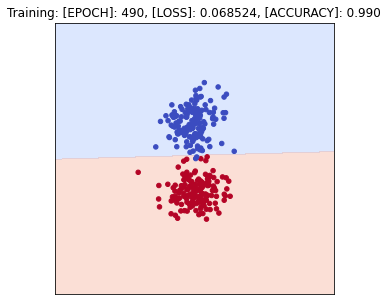

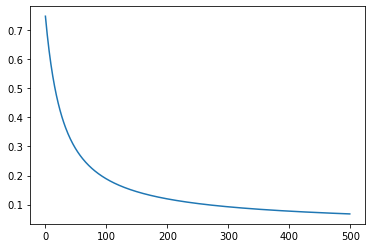

In [29]:
losses = train(x_train, y_train.float(), criterion, modelLogistic, optimizer, epochs=500, printEvery = 10)

plt.plot(losses)

We also might want to evaluate our final model over the validation set. We will use the same criterion as before. When evaluating, we do not need to calculate gradients, so we can tell PyTorch to skip this (this should make our code a bit faster)

In [30]:
# A helper function that calculates our loss and accuracy on a given dataset (by default on our validation set)
def evaluateModel(x, y, criterion, model):

    # set model in evaluation mode
    model.eval()
    with torch.no_grad(): # do not compute gradients for validation
        y_pred = model(x)
        y_pred = y_pred.squeeze()

    # compute loss and accuracy 
    predicted = (y_pred > 0.5)
    loss = criterion(y_pred, y)
    acc = (predicted == y_train).sum().float() / len(y_train)    

    return loss, acc

In [31]:
evaluateModel(x_val, y_val, criterion, modelLogistic)

(tensor(0.0736), tensor(0.5133))

Let's plot again the final result

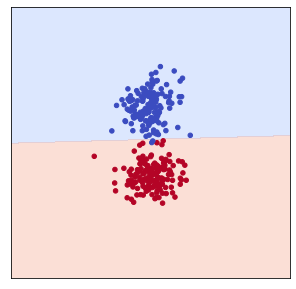

In [32]:
plt.figure( figsize = (5,5) )
plot_model(x_val, y_val, modelLogistic, plt.gca())

## 12.2 A non-linearly separable scenario

Now we will make things a bit more difficult, and define a scenario which is not linearly separable

In [33]:
from sklearn.datasets import make_circles

N = 300 # number of sample

x_train, y_train = make_circles(n_samples = N, noise = 0.1, random_state=7, factor=0.4) # training data
x_val, y_val = make_circles(n_samples = N, noise = 0.1, random_state=7, factor=0.4) # training data

In [34]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

(-2.0, 2.0)

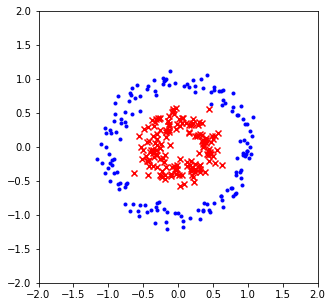

In [35]:
plt.figure(figsize = (5,5))
plt.scatter(x_train[y_train == 0,0], x_train[y_train == 0,1], marker = ".", c = "blue")
plt.scatter(x_train[y_train == 1,0], x_train[y_train == 1,1], marker = "x", c = "red")
plt.ylim(-2, 2)
plt.xlim(-2, 2)

We will also define our simple logistic model, although we do not expect it to do much here.

In [36]:
modelLogistic = nn.Sequential(
    nn.Linear(dIn, 1),
    nn.Sigmoid()
)

In [37]:
criterion = torch.nn.BCELoss()

In [38]:
learning_rate = 0.3

# we use the optim package to apply gradient descent for our parameter updates
optimizer = torch.optim.SGD(modelLogistic.parameters(), lr=learning_rate)

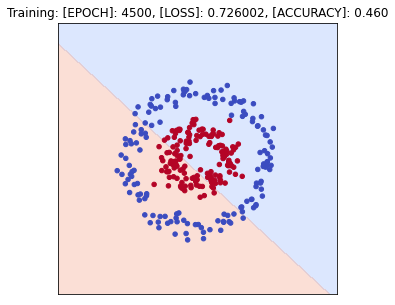

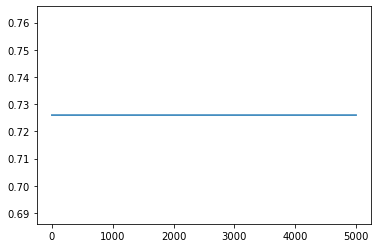

In [55]:
losses = train(x_train, y_train.float(), criterion, modelLogistic, optimizer, epochs=5000)

plt.plot(losses)

In [40]:
evaluateModel(x_val, y_val, criterion, modelLogistic)

(tensor(0.6930), tensor(0.4967))

As expected, our accuracy is close to 50%, meaning that the model is only able to classify half of the points correctly.

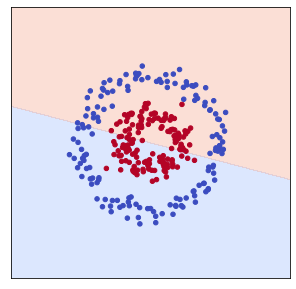

In [41]:
plt.figure( figsize = (5,5) )
plot_model(x_val, y_val, modelLogistic, plt.gca())

We should try a more complex model. Now we will add a hidden layer, with dimensionality 2 (two neurons in the hidden layer)

In [42]:
dIn = 2
dHidden = 2

modelMLP = nn.Sequential(
    nn.Linear(dIn, dHidden),
    nn.Sigmoid(),
    nn.Linear(dHidden, 1),
    nn.Sigmoid()
)

<font color=blue>Can you explain what the above model does? </font>

---

*YOUR RESPONSE HERE*

---


In [43]:
criterion = torch.nn.BCELoss()

In [44]:
learning_rate = 0.3

# we use the optim package to apply gradient descent for our parameter updates
optimizer = torch.optim.SGD(modelMLP.parameters(), lr=learning_rate)

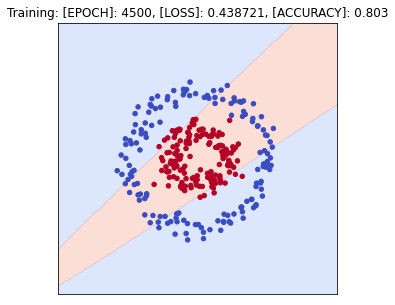

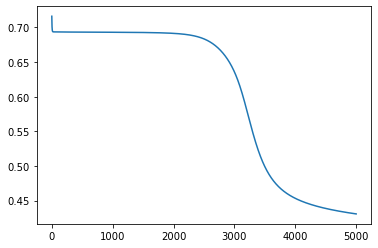

In [45]:
losses = train(x_train, y_train.float(), criterion, modelMLP, optimizer, epochs=5000)

plt.plot(losses)

In [46]:
evaluateModel(x_val, y_val, criterion, modelMLP)

(tensor(0.4308), tensor(0.8000))

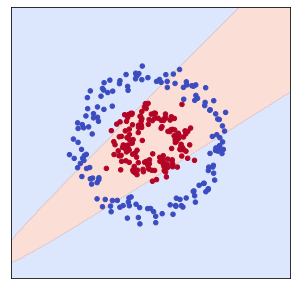

In [47]:
plt.figure( figsize = (5,5) )
plot_model(x_val, y_val, modelMLP, plt.gca())

<font color=blue>Can you change your network and train it again so that it has 3 neurons in the hidden layer? </font>

In [48]:
# YOUR CODE HERE


<font color=blue>Now train your new model for 7000 epochs? </font>

In [49]:
# YOUR CODE HERE


<font color=blue>Evaluate your model over the validation set. What is your accuracy? </font>

In [50]:
# YOUR CODE HERE


<font color=blue>How many parameters are there in the first layer? </font>

---

*YOUR RESPONSE HERE*

---


<font color=blue>Can you add one more hidden layer to your model, and train it again for an adecuate number of epochs? Then evaluate your solution over the validation set. </font>

In [51]:
# YOUR CODE HERE


## Annex

There is an alternative way to define neural networks in PyTorch, which provides much more flexibility. It involves creating a class for your model, that derives from the nn.Module class.

In the initialisation function of the class (that is executed automatically when you create an object of this class), you need to define all the elements that you will use: the layers and activation functions you will use.

There is a special function that is called `forward()` which is called by the framework every time a forward pass needs to be calculated, passing through the input data. You need to redefine this forward pass to treat the input data the way you want, which means define the sequence of operations that you want to apply to the input data.

In [52]:
dIn = 2
dHidden = 40

In [53]:
import torch.nn as nn

class SimpleMLP(nn.Module):

    def __init__(self, inDim, hiddenDim):
        super().__init__()
        self.fc1 = nn.Linear(inDim, hiddenDim)
        self.activation1 = nn.Sigmoid()
        self.fc2 = nn.Linear(hiddenDim, 1)
        self.activation2 = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.activation1(out)
        out = self.fc2(out)
        out = self.activation2(out)
        return out
    
modelMLP = SimpleMLP(dIn, dHidden)

In [54]:
import torch.nn as nn

class LogisticRegression(nn.Module):

    def __init__(self, inDim):
        super().__init__()
        self.fc1 = nn.Linear(inDim, 1)
        self.activation1 = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.activation1(out)
        return out
    
modelLogistic = LogisticRegression(dIn)